notebook can be run on the Freiburg cluster or on Dali. 
Change the path of files accordingly.
on dali files are on: /dali/lgrandi/xenonnt/simulations/er_simulations/rootfiles

In [2]:
%run 'init.ipynb'
%run 'geometry_checks.ipynb'  
# server = '/dali/lgrandi/xenonnt/simulations/er_simulations/rootfiles/'
server = '/userdata/arocchetti/rootfiles/'
print("server chosen is:", server)
from datetime import date
final_date = date(2020, 5, 1)
print(final_date)

server chosen is: /userdata/arocchetti/rootfiles/
2020-05-01


In [3]:
N = 100000000 #events generated in the root stage
m_fv = 4 #tons

#some files are corrupted, therefore we exclude them 
def number_of_events(material):
    N = 100000000
    if material == "SS_OuterCryostat":
        n = {
        'U238' :N-3000 ,
        'Co60' : N, 
        'K40' : N,
        'Cs137' : N,
        'Th228' : 999*100000, 
        'Th232' : N,    
        'U235' : N,
        'Ra226' : 995*900000,
        }
    if material == "SS_InnerCryostat":
        n = {
        'U238' :N ,
        'Co60' : N, 
        'K40' : N,
        'Cs137' : N,
        'Th228' : N, 
        'Th232' : N,
        'U235' : N,
        'Ra226' : 995*900000,
        }
    if material == "OuterCryostatReflector":
        n = {
        'U238' :N-3000 ,
        'Co60' : N, 
        'K40' : N,
        'Cs137' : N,
        'Th228' : N-1000, 
        'U235' : N,
        'Th232' : N-2000,
        'Ra226' : N,
        }  
    if material == "SS_BellPlate":
        n = {
        'U238' :N ,
        'Co60' : N-2000, 
        'K40' : N,
        'Cs137' : N,
        'Th228' : N, 
        'U235' : N,
        'Th232' : N,
        'Ra226' : N,
        }   
    if material == "SS_BellSideWall":
        n = {
        'U238' :N ,
        'Co60' : 990*100000, 
        'K40' : N,
        'Cs137' : N,
        'Th228' : N, 
        'U235' : N,
        'Th232' : N,
        'Ra226' : N,
        }  
    if material ==  "Teflon_TPC":
        n = {
        'U238' :N ,
        'Co60' : N -1000, 
        'K40' : N,
        'Cs137' : N,
        'Th228' : N, 
        'U235' : N,
        'Th232' : N,
        'Ra226' : N,
        }  
    if material ==  "Copper_FieldShaperRing_":
        n = {
        'U238' :N ,
        'Co60' : N -1000, 
        'K40' : N,
        'Cs137' : N,
        'Th228' : N, 
        'U235' : N,
        'Th232' : N,
        'Ra226' : N,
        }    
    if (  (material == "Teflon_Pillar_") 
                                       | (material == "PmtTpc")          |(material == "SS_AnodeRing")     
                                       |( material =="Teflon_BottomTPC") 
                                       | (material == "Copper_TopRing")  |(material ==  "Copper_TopRing") 
                                       | (material =="Copper_TopRing")   |  (material == "Copper_FieldGuard_") 
                                       | (material == "Copper_BottomPmtPlate") | (material == "PmtBases")
                                       ):
        n = {
        'U238' :N,
        'Co60' : N, 
        'K40' : N,
        'Cs137' : N,
        'Th228' : N, 
        'U235' : N,
        'Th232' : N,
        'Ra226' : N,
        }  
    
    return n



In [4]:
def get_xyz_root(rootfile):
    file = uproot.open(rootfile)
    tree = file["events/events"]
    xp = tree["xp_pri"].array()
    df = tree.pandas.df([ "xp_pri", "yp_pri", "zp_pri"])
    df.columns = ['X', 'Y', 'Z_uc'] #rename 
    #Add some variables
    df['R'] = np.sqrt(df.X*df.X+ df.Y*df.Y)
    df['R2'] = df.R*df.R
    offset = 1488/2
    df['Z'] = df.Z_uc+ offset
    return df

#function to read the root file in chuncks 
def get_xyz(rootfile):
    dataframe = []
    for df in read_root(rootfile, "events/events", 
                        chunksize = 1000000000,
                        columns= ["xpri", "ypri", "zpri", "epri", "ns", "X", "Y", "Z", "Ed"],
                        where=("ns==1"), 
                            ):#, unit = "chunks"):
        x_values=[x[0] for x in df.X]
        y_values=[y[0] for y in df.Y]
        z_values=[z[0] for z in df.Z]
        Ed_values = [Ed[0] for Ed in df.Ed]
        df["X"]=x_values
        df["Y"]=y_values
        df["Z"]=z_values
        df["Ed"]=Ed_values
        
        dataframe.append(df)
        if (len(dataframe)>0):
            dataframe=pd.concat(dataframe)
            dataframe.columns = ['xp', 'yp', 'zp_uc', "epri", "ns", "X", "Y", "Z_uc", "Ed"] #rename 
            offset = 1488/2
            dataframe['rp'] = np.sqrt(dataframe.xp**2+ dataframe.yp**2)
            dataframe['r2p'] = dataframe.rp*dataframe.rp
            dataframe['R'] = np.sqrt(dataframe.X**2+ dataframe.Y**2)
            dataframe['R2'] = (dataframe.R*dataframe.R)
            dataframe['Z'] = dataframe.Z_uc+offset
            dataframe['zp'] = dataframe.zp_uc+ offset

        break
    #print(len(dataframe))    
    #dataframe = dataframe[dataframe.typepri == isotope]
    #print(len(dataframe))
    return dataframe


In [44]:
def get_data(isotope, component):
    #return the correct root file to load according to the component
    df = pd.DataFrame()

    if component == "OuterCryostatShell":
        DATE = "XENONnT_20191202"
        material = "SS_OuterCryostat" 
        N_ = number_of_events(material)
        N = N_[isotope]
        rootfile = server +'output_'+ material + '_' + isotope +'_FINAL' + '.root'
        data = get_xyz(rootfile)
        if (len(data)>0):
            flange1, flange2, flange3, shell, elongation = divide_outercryo(data)
            fraction_shell, fraction_elong, fraction_flanges = outer_cryo_numbers(N)
            df = shell
            frac = fraction_shell 
        else:
            fraction_shell, fraction_elong, fraction_flanges = outer_cryo_numbers(N)
            frac = fraction_shell 
            return df, frac, material
    elif component == "OuterCryostat_Elongation":
        DATE = "XENONnT_20191202"
        material = "SS_OuterCryostat"
        N_ = number_of_events(material)
        N = N_[isotope]
        rootfile = server +'output_'+ material + '_' + isotope +'_FINAL' + '.root'
        data = get_xyz(rootfile)
        if len(data)>0:
            flange1, flange2, flange3, shell, elongation = divide_outercryo(data)
            df = elongation
            fraction_shell, fraction_elong, fraction_flanges = outer_cryo_numbers(N)
            frac = fraction_elong 
        else:
            fraction_shell, fraction_elong, fraction_flanges = outer_cryo_numbers(N)
            frac = fraction_elong
            return df, frac, material
    elif component == "OuterCryostat_flanges":
        DATE = "XENONnT_20191202"
        material = "SS_OuterCryostat"
        N_ = number_of_events(material)
        N = N_[isotope]
        rootfile = server +'output_'+ material + '_' + isotope +'_FINAL' + '.root'
        data = get_xyz(rootfile)
        if len(data)>0:
            flange1, flange2, flange3, shell, elongation = divide_outercryo(data)
            flanges = pd.concat([flange1, flange2, flange3])
            df = flanges
            fraction_shell, fraction_elong, fraction_flanges = outer_cryo_numbers(N)
            frac = fraction_flanges
        else:
            fraction_shell, fraction_elong, fraction_flanges = outer_cryo_numbers(N)
            frac = fraction_flanges
            return df, frac, material
    elif component == "SS_InnerCryostatShell":
        material = "SS_InnerCryostat" 
        N_ = number_of_events(material)
        N = N_[isotope]
        rootfile = server +'output_'+ material + '_' + isotope +'_FINAL' + '.root'
        data = get_xyz(rootfile)
        if len(data)>0:
            flange1_in, flange2_in, flange3_in, shell_in, elongation_in = divide_innercryo(data)
            flanges_in = pd.concat([flange1_in, flange2_in, flange3_in])
            fraction_shell, fraction_elong, fraction_flanges = inner_cryo_numbers(N)
            df = shell_in
            frac = fraction_shell
        else:
            fraction_shell, fraction_elong, fraction_flanges = inner_cryo_numbers(N)
            frac = fraction_shell
            return df, frac, material
    elif component == "SS_InnerCryostatFlanges":
        material = "SS_InnerCryostat" 
        N_ = number_of_events(material)
        N = N_[isotope]
        rootfile = server +'output_'+ material + '_' + isotope +'_FINAL' + '.root'
        data = get_xyz(rootfile)
        if len(data)>0:
            flange1_in, flange2_in, flange3_in, shell_in, elongation_in = divide_innercryo(data)
            flanges_in = pd.concat([flange1_in, flange2_in, flange3_in])
            fraction_shell, fraction_elong, fraction_flanges = inner_cryo_numbers(N)
            df = flanges_in
            frac = fraction_flanges
        else:
            fraction_shell, fraction_elong, fraction_flanges = inner_cryo_numbers(N)
            frac = fraction_flanges
            return df, frac, material
    elif component == "SS_InnerCryostat_bottomDome":
        material = "SS_InnerCryostat" 
        N_ = number_of_events(material)
        N = N_[isotope]
        rootfile = server +'output_'+ material + '_' + isotope +'_FINAL' + '.root'
        data = get_xyz(rootfile)
        if len(data)>0:
            flange1_in, flange2_in, flange3_in, shell_in, elongation_in = divide_innercryo(data)
            flanges_in = pd.concat([flange1_in, flange2_in, flange3_in])
            fraction_shell, fraction_elong, fraction_flanges = inner_cryo_numbers(N)
            frac = fraction_elong
            df = elongation_in
        else:
            fraction_shell, fraction_elong, fraction_flanges = inner_cryo_numbers(N)
            frac = fraction_elong
            return df, frac, material
    elif component == "SS_BellSideWall":
        material = 'SS_BellSideWall'
        N_ = number_of_events(material)
        N = N_[isotope]
        rootfile = server +'output_'+ material + '_' + isotope +'_FINAL' + '.root'
        data = get_xyz(rootfile)
        if len(data)>0:
            bottomLip, bellWall = divide_bellWall(data)
            fraction_side, fraction_lip = bell_wall_numbers(N)
            frac = fraction_side
            df = bellWall
        else:
            fraction_side, fraction_lip = bell_wall_numbers(N)
            frac = fraction_side
            return df, frac, material
    elif component == "SS_BellSideWallBottomLip":
        material = 'SS_BellSideWall'
        N_ = number_of_events(material)
        N = N_[isotope]
        rootfile = server +'output_'+ material + '_' + isotope +'_FINAL' + '.root'
        data = get_xyz(rootfile)
        if len(data)>0:
            bottomLip, bellWall = divide_bellWall(data)
            df = bottomLip 
            fraction_side, fraction_lip = bell_wall_numbers(N)
            frac = fraction_lip
        else:
            fraction_side, fraction_lip = bell_wall_numbers(N)
            frac = fraction_lip
            return df, frac, material
    elif component == "Top_PTFE_Frame":
        material = 'SS_Teflon_TopElectrodesFrame'
        N_ = number_of_events(material)
        N = N_[isotope]
        rootfile = server +'output_'+ material + '_' + isotope +'_FINAL' + '.root'
        data = get_xyz(rootfile)
        frac = 1
    elif component ==  "Teflon_TPC_Sliding":
        DATE = "XENONnT_20191202"
        material = "Teflon_TPC"
        N_ = number_of_events(material)
        N = N_[isotope]
        rootfile = server +'output_'+ material + '_' + isotope +'_FINAL' + '.root'
        df = get_xyz(rootfile)
        frac = 100
    elif component ==  "Teflon_TPC_Fixed":
        DATE = "XENONnT_20191202"
        material = "Teflon_TPC"
        N_ = number_of_events(material)
        N = N_[isotope]
        rootfile = server +'output_'+ material + '_' + isotope +'_FINAL' + '.root'
        df = get_xyz(rootfile)
        frac = 100
    elif component == "PmtBases":
        material = "PmtBases"
        N_ = number_of_events(material)
        N = N_[isotope]
        rootfile = server +'output_'+ material + '_' + isotope +'_FINAL' + '.root'
        df = get_xyz(rootfile)
        frac = 100
    else:
        material = component
        N_ = number_of_events(material)
        N = N_[isotope]
        rootfile = server +'output_'+ material + '_' + isotope +'_FINAL' + '.root'
        df = get_xyz(rootfile)
        frac = 100
    #print(rootfile)
    return df, frac, material



In [6]:
#material = "Copper_FieldShaperRing_"
#isotope_array = ["U238",
#                "Co60",
#                "K40",
#                "Cs137",
#                "Th228",
#                "U235",
#                "Th232",
#                "Ra226"
#                ]

#for isotope in isotope_array:
#    rootfile = server +'output_'+ material + '_' + isotope +'_FINAL' + '.root'
#    data = get_xyz(rootfile)
#    print(material, isotope, max(data.R))

In [7]:
#apply cuts to the dataframe: single scatter, fv, and energy ROI. If energy ROI is empty, extend it to 0-100 and re-normalize.
#assume the spectrum is flat 
isotope_array = ["U238",
                "Co60",
                "K40",
                "Cs137",
                "Th228",
                "U235",
                "Th232",
                "Ra226"
                ]
def calculate_events(data, isotope):
    
    events_passing = 0
    ss = single_scatter(data)
    fv_ = fv(ss)
    energy_ = energy(fv_, 0, 200)
    #print(len(energy_))
    if len(energy_) == 0:
        events_passing = 2.3 * (10/200)
        square_events_passing = np.sqrt(2.3) * (10/200) 
        #square_events_passing = 0
    
    else:
        events_passing = len(energy_)*(10/200)
        square_events_passing = np.sqrt(events_passing)*(10/200)
    return events_passing, square_events_passing

In [43]:
def do(component, m_fv): 
    #main function to calculate the rate
    conv = 3.1536*1e7 #conversion factor s->y
    rate_array = []
    error_array = []
    i = 0
    flag = 0
    total_str = ""  
    time_array = []
  
    for i in range(0, len(isotope_array)):
        note = " "
        isotope = isotope_array[i]
        data, frac, material = get_data(isotope, component) 
        
        N_ = number_of_events(material)
        N = N_[isotope]
        b = select_typepri(isotope) #return the normalization for the isotope chains
        n =  N * (frac/100) * (1/b) #n_gen * fraction events in that component * chain_factor
        n_events, square_events_passing = calculate_events(data, isotope)
        p = scale_activity(component, final_date)
        mass = p['mass']
        contamination = p[isotope] 
#         print("after", contamination)
        err = "err_"+isotope
        err = str(err)
        error_cont = p[err]/1000 #mBq->Bq
        contamination = p[isotope]/1000 
#         print(contamination)
        if error_cont == 0:
            note = "*"
        else:
            note = " "
        if (contamination == 0):
            rate = 0
            error_rate = 0
            str_ = ( "| no contamination value ")
            alpha = 0
            time = 0

        else:
            
            time = n / (mass * contamination)
            #print("----time for ", isotope, time/conv)
            rate = n_events/(time * m_fv ) #*E  #ev/s*t
            #print(n_events)
            #print("rate * conv", rate*conv)
            alpha = mass / (m_fv * n) #correct with mass*b/(m_fv*E*N_gen)  ##no energy   
            error_rate = alpha * np.sqrt((n_events * error_cont)**2 + (contamination*square_events_passing)**2)
                    
            if n_events == 2.3*10/200:
                str_ = ("| <%2.2g" %(rate*conv)) + note
                flag = flag +1
            else:
                str_ = ("|(%2.2g +- %2.2g)" %(rate*conv, error_rate*conv))+ note 
            
        rate_array = np.append(rate_array, rate)
        error_array = np.append(error_array, error_rate) 
        total_str = total_str  + str_ 
        if time == 0:
            time_array = np.append(time_array, time)  
        else:
            time_array = np.append(time_array, time/conv)
        #print("time", time*conv)
        #print("primaries", n)
        #print("mass", mass)
        #print("activity", contamination*1000 , "mBq/kg")
        
        i = i+1 
        tot_rate = 0
        tot_error_rate = 0
        if len(rate_array)!=0:
            for i in range(0, len(rate_array)):
                tot_rate = tot_rate + rate_array[i]
                tot_error_rate = tot_error_rate + error_array[i]
                if flag == 0:
                    total_rate_string = ("|(**%2.2g +- %2.2g)" %(tot_rate*conv, tot_error_rate*conv)+ "**|" )
                else:
                    total_rate_string = ("|**<%2.2g " %(tot_rate*conv)+ "**|") 
        else:
            total_rate_string = "|"        
    print("|" + component + total_str + total_rate_string)
    return tot_rate*conv, time_array
       
####################################################################################
isotope_array = ["U238", 
                "Co60",
                "K40","Cs137", "Th228","U235","Th232",
                "Ra226"
]
do("PmtTpc", 4)
#do("OuterCryostatShell", 4)
#do("SS_InnerCryostatFlanges", 4)
#do("OuterCryostat_Elongation", 4)

|PmtTpc|(3.4 +- 0.21) |(2.7 +- 0.28) |(5.5 +- 0.68) |(0.049 +- 0.0012) |(0.26 +- 0.048) |(0.2 +- 0.13) |(0.65 +- 0.65) |( 1 +- 0.19) |(**14 +- 2.2)**|


(13.775528067912001,
 array([ 0.12586248,  9.43968563,  0.47760314, 40.11866395,  3.82082514,
         0.14302554,  2.79086358,  1.45555243]))

In [9]:
def get_parameters(material):
    if material == "PmtBases":
        param = {
        'ids' : 'PmtBases',
        'mass' : 494, 
        'U238' : 1463/1000,
        'err_U238' : 140/1000,
        'Ra226' : 650/1000,
        'err_Ra226' : 25/1000,
        'Co60' : 2.94/1000,
        'err_Co60' : 0,
        'K40' : 287/1000, 
        'err_K40' : 45/1000,
        'Cs137' : 2.01/1000, 
        'err_Cs137' : 0, 
        'Th228' : 53/1000, 
        'err_Th228' : 3/1000, 
        'U235' : 1463*0.04/1000,
        'err_U235' :140*0.04/1000,
        'Th232' : 53/1000,
        'err_Th232' : 3/1000,   
        }
    if material == "OuterCryostatShell":
        param = {
        'ids' : 'XENON1T_OCS',
        'mass' : 569.400, 
        'U238' : 2.4,
        'err_U238' : 0.7,
        'Ra226' : 0.64, 
        'err_Ra226' : 0,
        'Co60' : 9.7,
        'err_Co60' : 0.8,
        'K40' : 2.7, 
        'err_K40' : 0,
        'Cs137' : 0.64, 
        'err_Cs137' : 0, 
        'Th228' : 0.36, 
        'err_Th228' : 0, 
        'U235' : 0.11,
        'err_U235' : 0.03,
        'Th232' : 0.21,
        'err_Th232' : 0.06,   
        }
           
    if material == "OuterCryostat_Elongation":
        param = {
        'ids' : "SS_NiT_C5",
        'mass' : 61.500 ,
        'U238': 4,
        'err_U238' : 2,
        'Ra226' : 1.34 ,
        'err_Ra226' : 0.09,
        'Co60' : 0.61,
        'err_Co60' :0.05, 
        'K40' :1.4 ,
        'err_K40' :0.2,
        'Cs137' : 0.034,
        'err_Cs137' : 0.017,
        'Th228' : 0.57,
        'err_Th228' : 0.06,
        'U235' : 0.31,
        'err_U235' : 0, 
        'Th232' :1.2,
        'err_Th232' : 0.2,  
        }
        
    if material == "OuterCryostat_flanges":
        param = {
        'mass':413.220,
        'ids':"XENON1T_OCF",
        'U238':1.4,
        'err_U238':0.4,
        'Ra226':4 ,
        'err_Ra226': 0,
        'Co60':37.3,
        'err_Co60': 0.9,
        'K40':5.6,
        'err_K40': 0,
        'Cs137':1.5,
        'err_Cs137':0,
        'Th228': 4.5,
        'err_Th228':0.6,
        'U235':0.06,
        'err_U235': 0.02,
        'Th232' : 0.21,
        'err_Th232' : 0.06,  
        }
    if material == "SS_InnerCryostatShell":
        param = {
         'mass' : 452.470 ,
         'ids' : "SS_NiT_C1",
         'U238' : 3.7,
         'err_U238' : 0.6,
         'Ra226' : 0.3 ,
         'err_Ra226' : 0.1,
         'Co60' : 2.36,
         'err_Co60' : 0.21,
         'K40' : 1.6,
         'err_K40': 0.6,
         'Cs137' : 0.21,
         'err_Cs137' : 0,
         'Th228' : 0.5,
         'err_Th228' : 0.1,
         'U235' : 0.7,
         'err_U235' : 0.3 ,
         'Th232' : 0.10 ,
         'err_Th232' : 0.08,
        }
    
    if material == "SS_InnerCryostatFlanges":
        param = { 
        'mass' : 227.500, #gr
        'ids' : "XENON1T_ICF",
        'U238' : 1.4,
        'err_U238' : 0.4,
        'Ra226' : 4 ,
        'err_Ra226' : 0,
        'Co60' : 37.3,
        'err_Co60' : 0.9,
        'K40' : 5.6,
        'err_K40' : 0,
        'Cs137' : 1.5,
        'err_Cs137' : 0,
        'Th228' : 4.5,
        'err_Th228' : 0.6,
        'U235' :  0.06,
        'err_U235' : 0.02,
        'Th232' : 0.21,
        'err_Th232' : 0.06,
       }
        
    if material == "SS_InnerCryostat_bottomDome":
        param = {
        'ids' : "SS_NiT_C5",
        'mass' :86.800, #g
        'U238': 4,
        'err_U238' : 2,
        'Ra226' : 1.34 ,
        'err_Ra226' : 0.09,
        'Co60' : 0.61,
        'err_Co60' :0.05, 
        'K40' :1.4 ,
        'err_K40' :0.2,
        'Cs137' : 0.034,
        'err_Cs137' : 0.017,
        'Th228' : 0.57,
        'err_Th228' : 0.06,
        'U235' : 0.31,
        'err_U235' : 0, #up
        'Th232' :1.2,
        'err_Th232' : 0.2,
        }
            
    
    if material =="OuterCryostatReflector":
        param = {
        'ids' : "ePTFE-A",
        'mass' : 18.660, #gr from mc
        'U238' : 0.27,
        'err_U238' : 0.12,
        'Ra226' : 0 ,
        'err_Ra226' : 0,
        'Co60' :  0,
        'err_Co60' : 0,
        'K40' : 0,
        'err_K40' : 0,
        'Cs137' :  0,
        'err_Cs137' :  0,
        'Th228' : 0.12,
        'err_Th228' : 0.4,
        'U235' :  0.27*0.04,
        'err_U235' :0.12*0.04,
        'Th232' : 0.12,
        'err_Th232' : 0.4,
        }
        
    if material == "SS_BellPlate":
        param = {
         'mass' : 63.66881, 
         'ids' : "SS_NiT_C1",
         'U238' : 3.7,
         'err_U238' : 0.6,
         'Ra226' : 0.3 ,
         'err_Ra226' : 0.1,
         'Co60' : 2.36,
         'err_Co60' : 0.21,
         'K40' : 1.6,
         'err_K40': 0.6,
         'Cs137' : 0.21,
         'err_Cs137' : 0,
         'Th228' : 0.5,
         'err_Th228' : 0.1,
         'U235' : 0.7,
         'err_U235' : 0.3,
         'Th232' : 0.10 ,
         'err_Th232' : 0.08,
        }   
        
    if material == "SS_BellSideWall":
        param = {
        'ids' : "SS_NiT_C5",
        'mass' :33.35405, 
        'U238': 4,
        'err_U238' : 2,
        'Ra226' : 1.34 ,
        'err_Ra226' : 0.09,
        'Co60' : 0.61  ,
        'err_Co60' :0.05, 
        'K40' :1.4 ,
        'err_K40' :0.2,
        'Cs137' : 0.034,
        'err_Cs137' : 0.017,
        'Th228' : 0.57,
        'err_Th228' : 0.06,
        'U235' : 0.31,
        'err_U235' : 0, #up
        'Th232' :1.2,
        'err_Th232' : 0.2,
        }
        
    if material == "SS_BellSideWallBottomLip":
        param = { 
         'mass' : 7.12738, #gr
         'ids' :"SS_Nit_e1",
         'U238' :2.5,
         'err_U238' : 0.3,
         'Ra226' : 0.6 ,
         'err_Ra226' : 0.1,
         'Co60' :0.4,
         'err_Co60' :0.1,
         'K40' :0.24,
         'err_K40' : 0,
         'Cs137' : 0.16,
         'err_Cs137' : 0,
         'Th228' : 0.4,
         'err_Th228' : 0.1,
         'U235' : 0.56,
         'err_U235' : 0,
         'Th232' :  0.4,
         'err_Th232' : 0.1,
        }
        
    
    if material =="Copper_TopRing":
        param = {
        'ids' : "[[xenon:xenonnt:screening:gamma_results:copper_nt_fs#activity_summary|Table]]",
        'mass' : 53.39539 + 84.97121, #gr 
        'U238': 0.33,
        'err_U238' : 0,
        'Ra226' : 0.17 ,
        'err_Ra226' : 0,
        'Co60' : 0.031  ,
        'err_Co60' :0, 
        'K40' : 0.45,
        'err_K40' :0.14,
        'Cs137' : 0.054,
        'err_Cs137' : 0,
        'Th228' : 0.18,
        'err_Th228' : 0.05,
        'U235' :0.33*0.04 ,
        'err_U235' : 0, #up
        'Th232':0.18,
        'err_Th232' : 0.05, 
        }
    
        
    if material == "Teflon_Pillar_":
        param = {
         'mass' : 28.95696+8.49816, #gr
         'ids' : "PTFE_Pillars",
         'U238' : 0.14,
         'err_U238' : 0.07,
         'Ra226' : 0.043,
         'err_Ra226' : 0.0011,
         'Co60' : 0,
         'err_Co60' : 0,
         'K40' : 0.42,
         'err_K40' : 0,
         'Cs137' : 0.013,
         'err_Cs137' : 0,
         'Th228' : 0.042,
         'err_Th228' : 0,
         'U235' : 0.049,
         'err_U235' : 0,
         'Th232': 0.105,
         'err_Th232' : 0.016, 
        }
        
        
    if material == "SS_AnodeRing":
        param = {
        'mass' : (1760+1914+1595+1508+1207)/1000, #gr
        'ids' :"SS_Nit_e1",
         'U238' :2.5,
         'err_U238' : 0.3,
         'Ra226' : 0.6 ,
         'err_Ra226' : 0.1,
         'Co60' :0.4,
         'err_Co60' :0.1,
         'K40' :0.24,
         'err_K40' : 0,
         'Cs137' : 0.16,
         'err_Cs137' : 0,
         'Th228' : 0.4,
         'err_Th228' : 0.1,
         'U235' : 0.56,
         'err_U235' : 0,
         'Th232' :  0.4,
         'err_Th232' : 0.1,
        } 
        
    if material == "Teflon_BottomTPC":
        param = {
         'mass': 0.22553,
         'ids': "PTFE_Holders-PTFE_Pillars",
         'U238': 0.14,
         'err_U238':  0.07,
         'Ra226': 0.064,
         'err_Ra226': 0,
         'Co60': 0,
         'err_Co60': 0,
         'K40':  7,
         'err_K40':  1,
         'Cs137':  0.22,
         'err_Cs137': 0,
         'Th228': 0.042,
         'err_Th228':  0,
         'U235':  0.070,
         'err_U235': 0,
         'Th232': 0.26,
         'err_Th232' : 0.12, 
        }
        
    if material == "Teflon_TPC_Sliding":
        param = { 
        'mass' : 7.57118, #kg
         'ids' : "PTFE_SlidingReflector",
         'U238' : 0.15,
         'err_U238' : 0.07,
         'Ra226' : 0.150 ,
         'err_Ra226' : 0.030,
         'Co60' :  0,
         'err_Co60' : 0,
         'K40' : 0.080,
         'err_K40' : 0.030,
         'Cs137' : 0.046,
         'err_Cs137' :  0,
         'Th228' : 0.079,
         'err_Th228' : 0,
         'U235' :  0.065,
         'err_U235' : 0,
         'Th232': 0.028,
         'err_Th232' : 0.0162,
        }
        
    if material == "Teflon_TPC_Fixed":
        param = { 
        'mass' : 11.6234, #gr
         'ids' : "PTFE_Ref2",
         'U238' : 0.032,
         'err_U238' :  0,
         'Ra226' :  0.032 ,
         'err_Ra226' : 0,
         'Co60' : 0,
         'err_Co60' :  0,
         'K40' : 8,
         'err_K40' :  1,
         'Cs137' :  0.066,
         'err_Cs137' :  0,
         'Th228' : 0.089,
         'err_Th228' : 0,
         'U235' :  0.078,
         'err_U235' :  0,
         'Th232': 0.12,
         'err_Th232' : 0.03,
        }
        
    if material == "Copper_FieldGuard_": 
        param = {
        'ids' : "CU_FS01",
         'mass' : 170.35648, #gr
         'U238' : 0.03,
         'err_U238' : 0.01,
         'Ra226' :  0 ,
         'err_Ra226' : 0,
         'Co60' : 0,
         'err_Co60' :  0,
         'K40' :  0,
         'err_K40' : 0,
         'Cs137' : 0,
         'err_Cs137' : 0,
         'Th228' : 0.010,
         'err_Th228' : 0.004,
         'U235' : 0.03 * 0.04 ,
         'err_U235' : 0.01 * 0.04,
         'Th232': 0.010,
         'err_Th232' :  0.004,
        }
        
    if material == "Copper_FieldShaperRing_":
        param = {
        'ids' : "CU_FSW",
        'mass' :8.49816,#gr
        'U238' : 3.31,
        'err_U238' : 0,
        'Ra226' : 9.08e-02 ,
        'err_Ra226' : 0,
        'Co60': 4.32e-01,  
        'err_Co60' : 3.79e-02,
        'K40' : 5.58e-01,
        'err_K40' : 2.33e-01,
        'Cs137' :3.49e-02 ,
        'err_Cs137' : 0,
        'Th228' : 3.61e-02,
        'err_Th228' :0,
        'U235' : 0.17,
        'err_U235' : 0  ,
        'Th232': 3.61e-02,
        'err_Th232' : 0,
        }
        
    if material == "Copper_BottomPmtPlate":
        param = {
        'ids' : "XENON1T",
        'mass' : 84.9712 + 53.39539,#gr
        'U238' : 1.2,
        'err_U238' : 0,
        'Ra226' : 0.033 ,
        'err_Ra226' : 0,
        'Co60': 0.1,
        'err_Co60' : 0.01,
        'K40' : 0.28,
        'err_K40' : 0,
        'Cs137' : 0.016,
        'err_Cs137' : 0,
        'Th228' : 0.034,
        'err_Th228' :0,
        'U235' : 0.55,
        'err_U235' : 0  , 
        'Th232': 0.043,
        'err_Th232' : 0,
        }
        
    if material == "PmtTpc":
        param =  {  
            'ids' : "average 1T/nT",
            'mass' :494, 
            'U238' : 10.20,
            'err_U238': 0.49,
            'Co60' : 0.68, 
            'err_Co60' : 0.068,
            'K40' : 13.44,
            'err_K40' : 1.65,
            'Cs137' : 0.16, 
            'err_Cs137' : 0.0026,
            'Th228' : 0.24, 
            'err_Th228' : 0.044,
            'U235' : 4.08, 
            'err_U235' : 0.009,
            'Th232' : 0.46, 
            'err_Th232' : 0.46,
            'Ra226' : 0.49, 
            'err_Ra226' : 0.09,

#        param = {
#        'ids' : "average 1T/nT",
#        'mass' :494, 
#        'U238': 10.20,
#        'err_U238' : 3.26,
#        'Ra226' : 0.49 ,
#        'err_Ra226' : 0.15,
#        'Co60' :0.94,  
#        'err_Co60' : 0.27, 
#        'K40' : 13.44  ,
#        'err_K40' : 2.89,
#        'Cs137' :0.17 ,
#        'err_Cs137' : 0.09,
#        'Th228' : 0.46,
#        'err_Th228' : 0.19,
#        'U235' : 10.20 *0.04,
#        'err_U235' :3.26 *0.04, #up
#        'Th232':0.46,
#        'err_Th232' : 0.19, 
        }
 
    return param


In [39]:
dates = {
    'SS_NiT_C5' : date(2018, 3, 1),
    'XENON1T_OCS' : date(2016, 7, 1), 
    'XENON1T_ICS' : date(2015, 12, 1),
    'XENON1T_OCF' : date(2012, 12, 1),
    'XENON1T_ICF' : date(2012, 12, 1),
    'XENON1T' : date(2015, 5, 1),
    'SS_NiT_C1' : date(2018, 1, 1),
    'SS_Nit_e1' : date(2018, 1, 1),
    'PTFE_Pillars' : date(2018, 12, 1), 
    'PTFE_Holders' : date(2018, 8, 1),
    'PTFE_SlidingReflector' : date(2019, 4, 1),
    'PTFE_Ref2' : date(2019, 8, 1),
    'CU_FS01' : date(2017, 7, 1),
    'CU_FSW' :date(2019, 5, 1),
    'PTFE_Holders-PTFE_Pillars' : final_date,
    '[[xenon:xenonnt:screening:gamma_results:copper_nt_fs#activity_summary|Table]]': final_date,
     'average 1T/nT' : final_date,
    'PmtBases': date(2019, 1,1)
    
    }

half_lives = {
    'Co60'  : 5.2713 * 365,
    'K40'   : 1.251e9 * 365  ,
    'U238'  : 4.468e9 * 365 ,
    'U235'  : 4.468e9 * 365,
    'Th232' : 1.405e10 * 365,
    'Th228' : 1.92 * 365 ,
    'Cs137' : 30.17 * 365,
    'Ra226' : 1600 * 365,
}


def diff_dates(date1, date2):
    return abs(date2-date1).days


def scale_activity(material, final_date):
    param = get_parameters(material)
    screen_id = param["ids"]
    initial_date = dates[screen_id]
    time_elapsed = diff_dates(initial_date, final_date)
#     print("Time elapsed since: ", initial_date, "is ", time_elapsed, "days")
    for isotope in isotope_array:
        cont = param[isotope]
        err_cont = param["err_"+isotope]
        L = np.log(2) / half_lives[isotope]
        new_cont = cont*np.exp(-time_elapsed*L)
        err_new_cont = err_cont * np.exp(-time_elapsed*L)
#         print(isotope, "old:", cont, "new: ", new_cont)
        update_dict = {isotope: new_cont, "err_"+ isotope: err_new_cont}
        param.update(update_dict)
    
    return param
print("final date for contamination scaling: ", final_date)

final date for contamination scaling:  2020-05-01


In [42]:
components = ["PmtTpc",
             "OuterCryostat_Elongation",
             "OuterCryostatShell", 
             "OuterCryostat_flanges",
             "SS_InnerCryostatShell",
             "SS_InnerCryostatFlanges",
             "SS_InnerCryostat_bottomDome",
             "SS_BellPlate",
             "SS_BellSideWall",
             "SS_BellSideWallBottomLip",
             "Teflon_Pillar_",#includes also pfte frame (Lxe + Gxe part)
             "SS_AnodeRing", #anode + all the electrodes 
             "Teflon_TPC_Sliding", #material is Teflon_TPC used twice for sliding and fixed
             "Teflon_TPC_Fixed",
             "Teflon_BottomTPC",
             "Copper_TopRing", #includes also bottom ring
             "Copper_FieldGuard_",
             "Copper_FieldShaperRing_",
             "Copper_BottomPmtPlate" #includes also top ring
             ]

isotope_array = ["U238",
                "Co60",
                "K40",
                "Cs137",
                "Th228",
                "U235",
                "Th232",
                "Ra226"
                ]



# scale_activity("PmtTpc", final_date)
# updates the value of key 2

    
#scale_activity("OuterCryostat_Elongation")

{'ids': 'average 1T/nT',
 'mass': 494,
 'U238': 10.2,
 'err_U238': 0.49,
 'Co60': 0.68,
 'err_Co60': 0.068,
 'K40': 13.44,
 'err_K40': 1.65,
 'Cs137': 0.16,
 'err_Cs137': 0.0026,
 'Th228': 0.24,
 'err_Th228': 0.044,
 'U235': 4.08,
 'err_U235': 0.009,
 'Th232': 0.46,
 'err_Th232': 0.46,
 'Ra226': 0.49,
 'err_Ra226': 0.09}

In [12]:
def fv(data):
    df = data[data['R']<607.34]
    df = df[df.Z_uc < -106.0]
    df = df[df.Z_uc > -1315.0]
    return df



In [13]:
def single_scatter(data):
    data = data[data.ns==1]
    return data


In [14]:

def select_typepri(isotope):
    if isotope=="U238":
        n = 5
    elif isotope=="U235":
        n = 11
    elif isotope=="Th232":
        n = 5
    elif isotope=="Th228":
        n = 7
    elif isotope=="Ra226":
        n = 9
    else:
        n = 1
    return n 

In [15]:
from matplotlib.ticker import ScalarFormatter

In [16]:
def energy(data, min, max):
    data = data[(data.Ed<max) & (data.Ed>min)]
    return data

In [17]:
#outercryo
N = 1e8
def outer_cryo_numbers(N):
    shell = 569.4
    elong = 61.5
    flanges = 413.22
    mass = shell + elong + flanges
    fraction_shell = (N * shell/mass)*(100/N)
    fraction_elong = (N * elong/mass)*(100/N)
    fraction_flanges =  (N * flanges/mass)*(100/N)
    return fraction_shell, fraction_elong, fraction_flanges
    print("fraction_shell %2.2f" %fraction_shell)
    print("fraction_elong %2.2f" %fraction_elong)
    print("fraction_flanges %2.2f" %fraction_flanges)
def inner_cryo_numbers(N):
    shell = 452.47
    elong = 86.8 
    flanges = 227.5 
    mass = shell + elong + flanges
    fraction_shell = (N* shell/mass)*(100/N)
    fraction_elong = (N* elong/mass)*(100/N)
    fraction_flanges =  (N * flanges/mass)*(100/N)
    return fraction_shell, fraction_elong, fraction_flanges
def bell_wall_numbers(N):
    bell_side = 33.35
    bell_lip = 7.12
    mass = bell_side+bell_lip
    fraction_side = (N* bell_side/mass)*(100/N)
    fraction_lip = (N* bell_lip/mass)*(100/N)
    return fraction_side, fraction_lip

In [18]:
#fraction_shell, fraction_elong, fraction_flanges = inner_cryo_numbers(N)
#print(fraction_shell, fraction_elong, fraction_flanges)


In [19]:
def return_frac(component):
    if component == "OuterCryostat_Elongation":
        fraction_shell, fraction_elong, fraction_flanges = outer_cryo_numbers(N)
        frac = fraction_elong 
    elif component == "OuterCryostatShell":
        fraction_shell, fraction_elong, fraction_flanges = outer_cryo_numbers(N)
        frac = fraction_shell
    elif component == "OuterCryostat_flanges":
        fraction_shell, fraction_elong, fraction_flanges = outer_cryo_numbers(N)
        frac = fraction_flanges
    elif component == "SS_InnerCryostatShell":
        fraction_shell, fraction_elong, fraction_flanges = inner_cryo_numbers(N)
        frac = fraction_shell
    elif component == "SS_InnerCryostatFlanges":
        fraction_shell, fraction_elong, fraction_flanges = inner_cryo_numbers(N)
        frac = fraction_flanges
    elif component == "SS_InnerCryostat_bottomDome":
        fraction_shell, fraction_elong, fraction_flanges = inner_cryo_numbers(N)
        frac = fraction_elong    
    elif component == "SS_BellSideWall":
        fraction_side, fraction_lip = bell_wall_numbers(N)
        frac = fraction_side 
    elif component == "SS_BellSideWallBottomLip":
        fraction_side, fraction_lip = bell_wall_numbers(N)
        frac = fraction_lip  
    else:
        frac=100
    return frac
      
      

In [20]:
def rate_array(component):
    m_fv = 4
    #main function to calculate the rate
    conv = 3.15*1e7 #conversion factor s->y
    rate_array = []
    i = 0
    time_array = []
    #rate_scaled = []
    
    for i in range(0, len(isotope_array)):
        note = " "
        isotope = isotope_array[i]
        print(isotope)
        data, frac, material = get_data(isotope, component) 
        N_ = number_of_events(material)
        N = N_[isotope]
        b = select_typepri(isotope) #return the normalization for the isotope chains
        n =  N*(frac/100)*(1/b) #n_gen * fraction events in that component * chain_factor
        
        n_events, square_events_passing = calculate_events(data, isotope)
 
        p = scale_activity(component, final_date)
        mass = p['mass']
        
        contamination = p[isotope]/1000 
        if (contamination == 0):
            rate = 0
            time = 0

        else:
            time = n / (mass * contamination)
            rate = n_events/(time * m_fv ) #*E  #ev/s*t           
            rate = rate * conv
        
        rate_array = np.append(rate_array, rate)
        
        if time == 0:
            time_array = np.append(time_array, time)  
        else:
            time_array = np.append(time_array, time/conv)
        
        i = i+1 
        tot_rate = 0
        if len(rate_array)!=0:
            for i in range(0, len(rate_array)):
                tot_rate = tot_rate + rate_array[i]
        rate_per_time = {isotope: rate_array*conv}
    

    return tot_rate, rate_array

# isotope_array = ["U238", "Ra226"]

# a, b = rate_array("PmtTpc")
# print(b)

In [21]:
# isotope_array = ["U238", "Ra226"]
def diff_dates_y(date1, date2):
    return abs(date2-date1).days / 365.25

def datapoints(yy, mm , dd, material):
    param = get_parameters(material)
    screen_id = param["ids"]
    final_date = date(yy, mm, dd)
    _ , rate_array_ = rate_array(material)
    initial_date = dates[screen_id]
    for i in range (0, len(isotope_array)):
        rate_scaled = [9]
        isotope = isotope_array[i]
        rate = rate_array_[i]
        while (initial_date < final_date):
            initial_date = datetime.date(initial_date.year, initial_date.month+1, 1)
            time_elapsed = diff_dates_y(initial_date, final_date)
            L = np.log(2) / half_lives[isotope]
            scaling = np.exp(-time_elapsed*L)
            rate_sc = rate * (1/scaling) 
            rate_scaled = np.append(rate_scaled, rate_sc)
            
        print(rate_scaled)
        
# datapoints(2020, 7, 1, "OuterCryostatShell")

In [22]:
import datetime

def scale_activity_each(material, isotope, yy, mm, dd):
    param = get_parameters(material)
    screen_id = param["ids"]
    initial_date = dates[screen_id]
    final_date = date(yy, mm, dd)
    while (initial_date < final_date):
        initial_date = datetime.date(initial_date.year, initial_date.month+1, 1)
        time_elapsed = diff_dates(initial_date, final_date)
        print("time elapsed betweeen", final_date , "and " , initial_date, "is", time_elapsed)
    cont = param[isotope]
    L = np.log(2) / half_lives[isotope]
    new_cont = cont*np.exp(-time_elapsed*L)
    
    return new_cont
# scale_activity_each("PmtTpc", "K40", 2020, 7, 1)

In [23]:
1/(0.1152*4)

2.170138888888889

In [24]:
# m_fv = 4
# components = [
#              "OuterCryostat_Elongation",
#              "OuterCryostatShell", 
#              "OuterCryostat_flanges",
#              "SS_InnerCryostatShell",
#              "SS_InnerCryostatFlanges",
#              "SS_InnerCryostat_bottomDome",
#              ]

# #function to return the rates nicely formatted
# def print_results(m_fv):
#     total_rate = []
#     times = []
#     print("^material ^", isotope_array[0], "^", isotope_array[1], "^", isotope_array[2], "^",isotope_array[3], "^", isotope_array[4],"^",
#              isotope_array[5], "^",isotope_array[6], "^",isotope_array[7], "^ Tot ^", )
#     for component in components:
#         tot_rate_per_comp, time = do(component, m_fv)
#         total_rate = np.append(total_rate, tot_rate_per_comp)
#     print("^Tot.^^^^^^^^^", "%4.4f" %(sum(total_rate)), "ev/t*y^")     

# print_results(m_fv) 


In [25]:
#print out the radioactivity values. 
components = ["OuterCryostat_Elongation",
             "OuterCryostatShell", 
             "OuterCryostat_flanges",
             "SS_InnerCryostatShell",
             "SS_InnerCryostatFlanges",
             "SS_InnerCryostat_bottomDome",
             #"OuterCryostatReflector",
             "SS_BellPlate",
             "SS_BellSideWall",
             "SS_BellSideWallBottomLip",
             "PmtTpc",
              "Copper_TopRing",
              "Copper_LowerRing",
              "Teflon_Pillar_",
              "SS_Electrodes",
              "Teflon_BottomTPC",
              "Teflon_TPC_Sliding",
              "Teflon_TPC_Fixed",
              "Copper_FieldGuard_",
              "Copper_FieldShaperRing_",
              "Top_PTFE_Frame",
              "Copper_BottomPmtPlate",
             "Copper_TopPmtPlate"]



def only_cont(component): 
    #p = get_parameters(component)
    p = scale_activity(component, final_date)
    screen_id = (p["ids"])
    total_str = ("|%s" %screen_id)
    for i in range(0, len(isotope_array)):
        isotope = isotope_array[i]
        
        mass = p['mass']
        contamination = p[isotope] 
        err = "err_"+isotope
        err = str(err)
        error_cont = p[err]
        
        contamination = p[isotope]
        if (contamination == 0):
            str_ = ("|<color #ed1c24>no contamination value</color>")
        else:
            str_ = ("|%2.2f  +- %2.2f" %(contamination, error_cont))
        total_str = total_str  + str_ 
               
    print("|" + component + total_str + "|" + "%2.f "%mass + "kg |")

def print_cont():
   # print("^material ^ screening_id ^", isotope_array[0], "^", isotope_array[1], "^", isotope_array[2], "^",isotope_array[3], "^", isotope_array[4],"^",
   #          isotope_array[5], "^",isotope_array[6], "^",isotope_array[7], "^mass^"  )
    for component in components:
        if component == "Copper_LowerRing":
            print("|Copper_LowerRing|[[xenon:xenonnt:screening:gamma_results:copper_nt_fs#activity_summary|Table]]|0.33  +- 0.00|0.03  +- 0.00|0.45  +- 0.14|0.05  +- 0.00|0.18  +- 0.05|0.01  +- 0.00|0.18  +- 0.05|0.17  +- 0.00|")
        elif component =="SS_Electrodes":
            only_cont("SS_AnodeRing")
        elif component == "Top_PTFE_Frame":
            print("|Top_PTFE_Frame|PTFE_Pillars|0.14  +- 0.07|<color #ed1c24>no contamination value</color>|0.42  +- 0.00|0.01  +- 0.00|0.04  +- 0.00|0.05  +- 0.00|0.10  +- 0.02|0.04  +- 0.00|")
        elif component == "Copper_TopPmtPlate":
            print("|Copper_TopPmtPlate|1t MC paper|1.20  +- 0.00|0.10  +- 0.01|0.28  +- 0.00|0.02  +- 0.00|0.03  +- 0.00|0.55  +- 0.00|0.04  +- 0.00|0.03  +- 0.00|")
        else:

            only_cont(component)

#print_cont()      

In [26]:
def plot_total_contribution_old(bins, min_val, max_val ):
    bins_ = bins 
    min_ = min_val
    max_ = max_val
    bin_width = (max_ - min_)/bins_
    values = np.zeros(bins) 
    for component in components:
        print("working on:" , component)
        for i in range(0, len(isotope_array)):
            isotope = isotope_array[i]
            data, frac, material = get_data(isotope, component)
            N_ = number_of_events(material)
            N = N_[isotope]
            data = fv(data)
            b = select_typepri(isotope) #later on with the good function
            n =  N*(frac/100)*(1/b) #n_gen * fraction in that component * chain_factor
            p = get_parameters(component)
            mass = p['mass']
            contamination = p[isotope] 
            if contamination > 0:
                contamination = p[isotope]/1000 
                time = n / (mass * contamination)
                time_weights = [1/time]*len(data)
            else:          
                print("no contamination for ", isotope)
                break
            m, bins_plt, = np.histogram(data.Ed, bins = bins_, range = (min_, max_), weights = time_weights)            
            plt.yscale("log")              
            values = values + m
    return values, bins_plt, bin_width



In [27]:
def plot_total_contribution(bins_, min_, max_):
    bin_width = ((max_ - min_)/bins_)
    values = np.zeros(bins_) 
    for component in components:
        print("working on:" , component)
        for i in range(0, len(isotope_array)):
            isotope = isotope_array[i]
            print(isotope, "-----------", len(values))
            data, frac, material = get_data(isotope, component)
            N_ = number_of_events(material)
            N = N_[isotope]
            data = fv(data)
            b = select_typepri(isotope) #later on with the good function
            n =  N*(frac/100)*(1/b) #n_gen * fraction in that component * chain_factor
#             p = get_parameters(component)  
            p = scale_activity(component, final_date)
            mass = p['mass']
            contamination = p[isotope] 
            if contamination > 0:
                contamination = p[isotope]/1000 
                time = n / (mass * contamination)
                time_weights = [1/time]
                m, bins_plt, = np.histogram(data.Ed, bins = bins_, range = (min_, max_))            
                plt.yscale("log")
                m = m * time_weights * (1/bin_width)
                values = values + m
            else:          
                print("no contamination for ", isotope)
                continue

            
    return values, bins_plt
#print("ok")


In [28]:
def make_spectrum(values, name, bins,min_val, max_val):
    for i in range (0, len(values)):
        conv = 864/(40) 
        values[i] = values[i]*conv
    plt.hist(bins_plt[:-1], bins_plt, weights=values, histtype = "step", label = name)
    plt.legend(markerscale=10, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='xx-large')
    plt.yscale("log")
    plt.ylabel("rate [ev/kg*day*keV]")
    plt.xlabel("Energy [keV]")
#     plt.title("ER from materials")
    plt.show() 
    map_ = values.tolist()
    data_map={'description': 'Preliminary background from materials .\nRate is in kg/d/KeV.\n \nArianna Rocchetti, Dec.2019\n', 
          'name': name,
          'coordinate_system': [['E', [min_val, min_val, bins]]],
          'map': map_}
    string_name = name+".json"
    with open(string_name, 'w') as fp:
        json.dump(data_map, fp)
        print("file saved as:" , string_name)

In [29]:
def load_files():

    with open('Cryostat.json') as json_file:
        cryo = json.load(json_file)
    with open('Bell.json') as json_file:
        bell = json.load(json_file)   
    with open('pmt.json') as json_file:
        pmt = json.load(json_file)   
    with open('Teflon.json') as json_file:
        teflon = json.load(json_file)   
    with open('Copper.json') as json_file:
        copper = json.load(json_file) 
    with open('electrodes.json') as json_file:
        electrodes = json.load(json_file) 
    total = np.zeros(len(cryo["map"]))
    for i in range(0, len(cryo["map"])):
        total[i]= cryo["map"][i] + bell["map"][i] + pmt["map"][i]+teflon["map"][i]+copper["map"][i]+electrodes["map"][i]
    
    return total, cryo, bell, pmt, teflon, copper, electrodes
#total, cryo, bell, pmt, teflon, copper, electrodes = load_files()

In [30]:
def plot_bello(total, cryo, bell, pmt, teflon, copper, electrodes):
    plt.hist( bins_plt, bins_plt, weights =  cryo["map"],histtype = "step",  label = "Cryostat")
    plt.hist( bins_plt, bins_plt, weights = bell["map"], histtype = "step",label = "Bell")
    plt.hist( bins_plt, bins_plt, weights =  pmt["map"], histtype = "step",label = "Pmts")
    plt.hist( bins_plt, bins_plt, weights =  copper["map"], histtype = "step",label = "Copper")
    plt.hist( bins_plt, bins_plt, weights =  electrodes["map"] , histtype = "step",label = "Electrodes")
    plt.hist( bins_plt, bins_plt, weights =  teflon["map"] ,histtype = "step", label = "Teflon")
    plt.hist( bins_plt, bins_plt, weights =  total, histtype = "step", color = "black", label = "Tot")
    plt.legend(markerscale=10, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='x-large')
    plt.yscale("log")
    plt.ylabel("rate [ev/kg*day*keV]")
    plt.xlabel("Energy [keV]")
    plt.title("ER from materials")
    plt.show()
#plot_bello(total, cryo, bell, pmt, teflon, copper, electrodes)

In [31]:
def plot_line200kev():
    fig = plt.figure()
    fig.patch.set_facecolor('xkcd:white')
    bins_plt = np.arange(0, 2500, 10)
    plt.hist(bins_plt, bins_plt, weights = bell["map"], histtype = "step", color = "black")
    plt.yscale("log")
    plt.axvline(x=200)
    plt.ylabel("rate [ev/kg*day*keV]")
    plt.xlabel("Energy [keV]")
    plt.show()
  

In [32]:
#2023: 
8.4676 + 1.2591 + 0.1545 + 0.4079 + 14.8921


25.181199999999997

In [33]:
#2024
7.7278 + 1.1538 + 0.1539 + 0.3734 + 14.8915

24.300400000000003

In [34]:
#2025
7.0845 + 1.062 + 0.3458 + 14.89 + 0.0054

23.387700000000002

In [35]:
#2021 
10.59 + 1.502 + 0.1566 + 0.4878 + 14.2735

27.009900000000002

[2.87  2.7   2.518 2.43  2.338]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3319: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


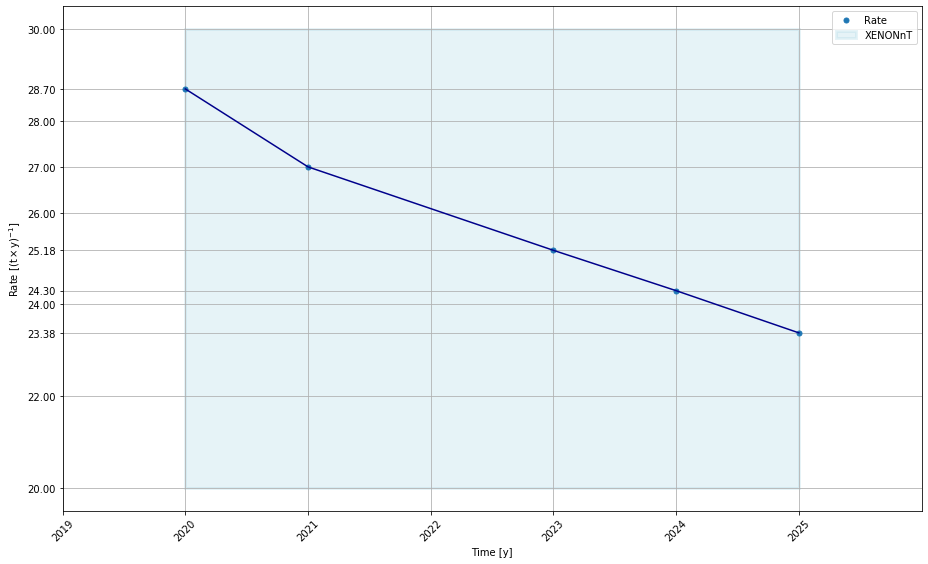

In [36]:
# fig, ax = plt.subplots()
dates =       [ 2020, 2021,  2023,  2024,  2025]
data_points = [ 28.7, 27.00, 25.18,  24.3, 23.38]

dates = np.asarray(dates)
data_points= np.asarray(data_points)

err_datapoints = []

for i in range(0, len(data_points)):
    err_datapoints = np.append(err_datapoints, data_points[i]*0.1)
    
print(err_datapoints)
# degree_of_fit = 8
# z = np.polyfit(dates, data_points, degree_of_fit)
# f = np.poly1d(z)                # So we can call f(x)
plt.figure(figsize=(13,8))
# ax = plt.errorbar(dates, data_points, yerr = err_datapoints, label="Rate", markersize = 10)
ax = plt.plot(dates, data_points, ".", label="Rate", markersize = 10)
# plt.plot(dates,f(dates), markersize = 2, color='red',label="Polyfit with %d degrees  " %degree_of_fit)
axes= plt.axes()
plt.xticks(rotation = 45)
ticks = [ 30, 28.7,28, 27.00, 26, 25.18,24,  24.3,22, 23.38, 20]
axes.set_yticks(ticks)
plt.xlabel("Time [y]")
plt.ylabel(r"Rate [(t$\,$$\times$$\,$y)$^{-1}$]")

xticks = np.arange(2019, 2026, 1)
axes.set_xticks(xticks) 
axes.grid()

currentAxis = plt.gca()

#currentAxis.add_patch(Rectangle((2015, 10), 3, 10, angle=0.0, alpha =0.3, color = "pink", linewidth=3, label = "XENON1T"))
#currentAxis.add_patch(Rectangle((2018, 10), 2, 10, angle=0.0, alpha =0.3, color = "lightblue", linewidth=3, label = "Shutdown"))
currentAxis.add_patch(Rectangle((2020, 20), 5, 10, angle=0.0, alpha =0.3, color = "lightblue", linewidth=3, label = "XENONnT"))

plt.legend()
plt.tight_layout()



x = dates
y = data_points
z = np.polyfit(x, y, 8)
f = np.poly1d(z)  
plt.plot(x, f(x), color="DarkBlue")
plt.xlim(2019, 2026)


plt.show()



[2.87  2.7   2.518 2.43  2.338]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3319: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


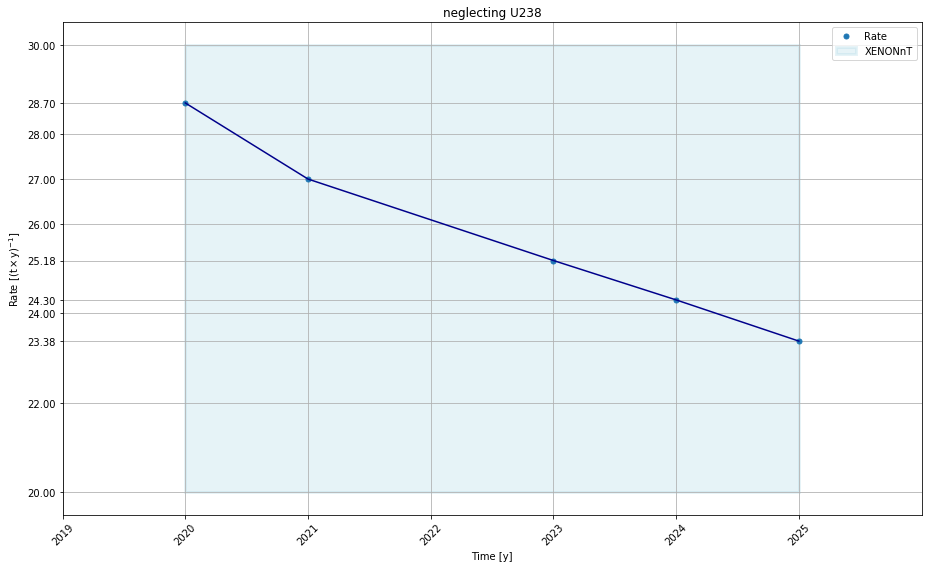

In [37]:
# fig, ax = plt.subplots()
dates =       [ 2020, 2021,  2023,  2024,  2025]
data_points = [ 28.7, 27.00, 25.18,  24.3, 23.38]

dates = np.asarray(dates)
data_points= np.asarray(data_points)

err_datapoints = []

for i in range(0, len(data_points)):
    err_datapoints = np.append(err_datapoints, data_points[i]*0.1)
    
print(err_datapoints)
# degree_of_fit = 8
# z = np.polyfit(dates, data_points, degree_of_fit)
# f = np.poly1d(z)                # So we can call f(x)
plt.figure(figsize=(13,8))
# ax = plt.errorbar(dates, data_points, yerr = err_datapoints, label="Rate", markersize = 10)
ax = plt.plot(dates, data_points, ".", label="Rate", markersize = 10)
# plt.plot(dates,f(dates), markersize = 2, color='red',label="Polyfit with %d degrees  " %degree_of_fit)
axes= plt.axes()
plt.xticks(rotation = 45)
ticks = [ 30, 28.7,28, 27.00, 26, 25.18,24,  24.3,22, 23.38, 20]
axes.set_yticks(ticks)
plt.xlabel("Time [y]")
plt.ylabel(r"Rate [(t$\,$$\times$$\,$y)$^{-1}$]")
plt.title("neglecting U238")
xticks = np.arange(2019, 2026, 1)
axes.set_xticks(xticks) 
axes.grid()

currentAxis = plt.gca()

#currentAxis.add_patch(Rectangle((2015, 10), 3, 10, angle=0.0, alpha =0.3, color = "pink", linewidth=3, label = "XENON1T"))
#currentAxis.add_patch(Rectangle((2018, 10), 2, 10, angle=0.0, alpha =0.3, color = "lightblue", linewidth=3, label = "Shutdown"))
currentAxis.add_patch(Rectangle((2020, 20), 5, 10, angle=0.0, alpha =0.3, color = "lightblue", linewidth=3, label = "XENONnT"))

plt.legend()
plt.tight_layout()



x = dates
y = data_points
z = np.polyfit(x, y, 8)
f = np.poly1d(z)  
plt.plot(x, f(x), color="DarkBlue")
plt.xlim(2019, 2026)


plt.show()

